## Instruction
In this notebook, We use data which I donwload from Tushare to make up some alpha factors and risk factors.
1. Load data from Tushare time range bettwen 2017.1 - 2023.3.
2. Calculate portfolio risk by PCA and save idiosynchritic values view a factor
3. Make up some factors like we did in P4 project.
5. Evaluate factor returns in 5D, 20D, 60D, 120D. and seperate factors into two parts, risk factors and alpha factors.

## Load Data

In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

import warnings
warnings.filterwarnings('ignore')

In [3]:
universe_raw = pd.read_csv('raw_20170103_20230317.csv').iloc[:,1:]
fundamental_df = pd.read_csv('fundamental_20170103_20230317.csv').iloc[:,1:]

In [4]:
# remove duplicates rows
unique_ticker = universe_raw.ts_code.unique()
universe = pd.DataFrame()

for i in tqdm(range(len(unique_ticker)), desc='remove duplicates'):
    tmp = universe_raw.loc[universe_raw.ts_code == unique_ticker[i]].drop_duplicates(['trade_date'])
    universe = universe.append(tmp, ignore_index=True)

remove duplicates: 100%|██████████████████████| 746/746 [02:16<00:00,  5.45it/s]


## Data Explain
  Fundamental indicators
  - 'cfps','revenue_ps', 'quick_ratio',  每股现金流，每股营业收入，速冻比率
  - 'dt_eps','basic_eps_yoy','dt_eps_yoy',  每股收益
  - 'bps','bps_yoy',  每股净资产
  - 'extra_item','profit_dedt', 扣非，扣非净利润
  - 'roe_dt','q_dt_roe','roe_yoy',  净资产收益
  - 'capital_rese_ps','surplus_rese_ps',  每股资本公积，每股公积盈余 
  - 'gross_margin','interestdebt','ca_to_assets', 毛利，带息债务, 流动资产/总资产
  - 'ebt_yoy','roe_yoy','or_yoy','equity_yoy' 总利润增长，净资产收益增长，营业收入增长，净资产增长

In [19]:
#print(universe_raw.shape, len(fundamental_df.ts_code.unique()))
print(universe_raw.columns)
#universe_raw.loc[universe_raw.ts_code=='603538.SH']

Index(['ts_code', 'trade_date', 'turnover_rate', 'volume_ratio', 'pe', 'pb',
       'total_share', 'free_share', 'total_mv', 'circ_mv', 'name', 'industry',
       'list_date', 'amount', 'adj_factor', 'open', 'close', 'high', 'low',
       'macd', 'rsi_6', 'rsi_12', 'rsi_24', 'boll_upper', 'boll_mid',
       'boll_lower', 'cci', 'date', 'pct_change', 'type', 'p_change_min',
       'p_change_max', 'issue_price', 'issue_amount', 'type_value', 'cfps',
       'revenue_ps', 'quick_ratio', 'dt_eps', 'basic_eps_yoy', 'dt_eps_yoy',
       'bps', 'bps_yoy', 'extra_item', 'profit_dedt', 'roe_dt', 'q_dt_roe',
       'roe_yoy', 'capital_rese_ps', 'surplus_rese_ps', 'gross_margin',
       'interestdebt', 'ca_to_assets', 'ebt_yoy', 'roe_yoy.1', 'or_yoy',
       'equity_yoy', 'volume'],
      dtype='object')


## Add Technology Indicators

In [6]:
# add volume
universe_raw['volume'] = universe_raw['amount']/universe_raw['close']

In [7]:
import stockstats

class IndicatorHelper(pd.DataFrame):
    """
        add indicators to dataframe
    """

    def __init__(self, data):
        super(IndicatorHelper, self).__init__(data)

        self.stocks = stockstats.StockDataFrame.retype(data.copy())
        self.df = self

    def add_technical_indicator(self, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param ticker: (df) pandas dataframe
        :param tech_indeicator_list list
        :return: (df) pandas dataframe
        """
        unique_ticker = self.df.ts_code.unique()

        indicator_df = pd.DataFrame()
        for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
            temp_indicator = self.stocks[self.stocks.ts_code == unique_ticker[i]]
            temp_indicator = temp_indicator[tech_indicator_list + ['ts_code','trade_date']]
            indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
        
        indicator_df = indicator_df.drop_duplicates(['trade_date','ts_code'])
        self.df = self.df.merge(indicator_df, on=["ts_code", "trade_date"], how="inner")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date']).drop_duplicates(['trade_date','ts_code'])
        return self.df
    

In [8]:
# add tech indicators
tech_indicator_list = ['supertrend','close_5_sma','close_20_sma','close_60_sma',
                       'log-ret','atr_5','cci_6', 
                       'close_10_kama_2_30', 'close_10_kama_5_30','close_2_kama'] 
universe = IndicatorHelper(universe_raw).add_technical_indicator(tech_indicator_list)
# 'close_2_kama_20_mstd'

add tech indicators: 100%|████████████████████| 746/746 [10:24<00:00,  1.19it/s]


## Constructor Factors Based on Indicators

### Supertrend Factors
This factor based on supertrend and close 5 days sma

In [10]:
universe['alpha_supertrend'] = universe['close_5_sma'] - universe['supertrend']

### CCI Factors
This factor based on cci and atr 5 days window

In [11]:
universe['alpha_cci'] = -np.where(universe['cci_6']>200, (universe['cci_6']-200)*universe['atr_5'], \
                      np.where(universe['cci_6']<-200, (universe['cci_6']+200)*universe['atr_5'], universe['atr_5']*30))

### KAMA Factors

In [12]:
# add KAMA alpha factor
def KAMA_filter(df):    
    unique_stocks = df.ts_code.unique()
    all_df = pd.DataFrame()
    for ts_code in tqdm(unique_stocks, desc='kama filter'):
        tmp = df.loc[df.ts_code == ts_code]
        tmp['close_2_kama'] = tmp['close_2_kama'].fillna(method='ffill')
        tmp['kama_filter'] = tmp['close_2_kama'].rolling(window=20).std().fillna(method='bfill') * 0.6
        tmp['kama_prior'] = tmp['close_2_kama'].shift(-5).fillna(method='ffill')
        tmp['alpha_kama'] = (tmp['close_10_kama_2_30'] - tmp['close_10_kama_5_30'])-(tmp['close_2_kama'] - tmp['kama_prior'] - tmp['kama_filter'])
        #tmp['alpha_kama'] = -(tmp['close_2_kama'] - tmp['kama_prior'] - tmp['kama_filter'])
        all_df = all_df.append(tmp[['ts_code','trade_date','alpha_kama']], ignore_index=True)
    df = df.merge(all_df, on=['ts_code','trade_date'], how='left')
    df['date'] = pd.to_datetime(df['trade_date'],format='%Y%m%d')
    df = df.set_index(['date']).sort_values(by=['date'])
    return df

universe = KAMA_filter(universe)

kama filter: 100%|████████████████████████████| 746/746 [00:53<00:00, 13.97it/s]


## Constructor Factors Based on Paper

### Overnight Return
This factor we had did in P4

$factor=(open_{today}-close_{yesterday})\div close_{yesterday}$

5 days sma of this factor as long factor and 20 sma as short factor 

In [13]:
class CloseToOpen(pd.DataFrame):
    """
        Overnight Return Factor Constructor
    """
    def __init__(self,data):
        super(CloseToOpen, self).__init__(data)
        self.df = self

    def calculate(self):
        '''
        add open-close as a column named close_to_return
        :return: dataframe
        '''
        unique_ticker = self.df.ts_code.unique()
        tmp_df = pd.DataFrame()
        for ts_code in tqdm(unique_ticker, desc='close_to_open'):
            stock = self.df.loc[self.df.ts_code == ts_code][["ts_code", "trade_date", "open", "close"]]
            stock['alpha_close2open'] = (stock['open'].shift(-1).fillna(method='ffill') - stock['close'])/stock['close']
            tmp_df = tmp_df.append(stock, ignore_index=True)
        self.df = self.df.merge(tmp_df[["ts_code", "trade_date", "alpha_close2open"]], on=["ts_code", "trade_date"], how="inner")
        self.df['date'] = pd.to_datetime(self.df['trade_date'], format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date'])
        return self
    
    def get_sma_factors(self):
        '''
        calculate close_to_open_5_sma, close_to_open_25_sma by IndicatorHelper class
        :return: Dateframe
        '''
        self.df = IndicatorHelper(self.df).add_technical_indicator(['alpha_close2open_5_sma', 'alpha_close2open_20_sma'])
        self.df['alpha_close2open_20_sma'] = - self.df['alpha_close2open_20_sma']
        return self.df
    

universe = CloseToOpen(universe).calculate().get_sma_factors()

add tech indicators: 100%|████████████████████| 746/746 [00:55<00:00, 13.46it/s]


### Winner And Loser
This factor we also did in P4. It express a ticker how to reach a return in a spicific period time 

We use a time window as T, and regression d and v $return = T*d + T^2*v$  => $factor=d*v$ 

In [13]:
from statsmodels.formula.api import ols

class WinnerAndLoser(pd.DataFrame):
    """
        Winner and Loser Factor Constructor
    """
    def __init__(self,data, win_length=20):
        super(WinnerAndLoser, self).__init__(data)
        self.df = self
        self.win_lenth = win_length

    def _regression(self, data):
        df = pd.DataFrame(data, columns=['log-ret'])
        df['acc_ret'] = df['log-ret'].cumsum()
        df['t_dir'] = np.arange(self.win_lenth)+1
        df['t_velocity'] = df['t_dir'] ** 2
        regression = ols(formula='acc_ret ~ 0 + t_dir + t_velocity', data=df)
        model = regression.fit()
        data['alpha_winlos'] = -model.params.t_dir * model.params.t_velocity
        return  data['alpha_winlos']


    def calculate(self):
        '''
        convert time to value
        regress return to get mu and beta each time
        add facotor mu*beta to colomns
        :return: dataframe
        '''
        tickers = self.df.ts_code.unique()
        factor_df = pd.DataFrame()
        for ticker in tqdm(tickers, desc='winner and loser'):
            tmp_df = self.df.loc[self.df.ts_code == ticker][['trade_date', 'ts_code', 'log-ret']]
            tmp_df['alpha_winlos'] = tmp_df['log-ret'].rolling(self.win_lenth).apply(self._regression)
            tmp_df['alpha_winlos'].fillna(method='bfill',inplace=True)
            factor_df = factor_df.append(tmp_df, ignore_index=True)
        self.df = self.df.merge(factor_df[["ts_code", "trade_date", "alpha_winlos"]], on=["ts_code", "trade_date"], how="left")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date'])
        return  self.df
    
    
#test = universe.loc[universe.ts_code=='603538.SH']
#test = universe.loc[universe.ts_code=='002038.SZ']
#test = WinnerAndLoser(test).calculate()
universe = WinnerAndLoser(universe).calculate()

winner and loser: 100%|██████████████████████████████████████████████████████████████| 122/122 [02:57<00:00,  1.46s/it]


### Skew And Momentum
This factor we also did in P4. It express minority and majority sentiment of investor how to impact on market.

We calculate skew and median of log-return distribution in a period time, the skew view as marjority sentiment and median can view as minority sentiment.

$factor = abs(skew) * median * volume\_ratio$

In [14]:
class SkewandMomentum(pd.DataFrame):
    """
        Expected Skewness and Momentum Factor Constructor
    """
    def __init__(self,data, win_length=10):
        super(SkewandMomentum, self).__init__(data)
        self.df = self
        self.win_length = win_length

    def calculate(self):
        '''
        convert time to value
        regress return to get mu and beta each time
        add facotor mu*beta to colomns
        :return: dataframe
        '''
        def calculate_factor(data):
            return abs(data.skew()) * data.median()
        
        tmp_df = pd.DataFrame()
        for stock_tuple in tqdm(self.groupby('ts_code'), desc='skew and momentum'):
            stock = stock_tuple[1]
            stock['alpha_skew2sentiment'] = stock['log-ret'].rolling(self.win_length).apply(calculate_factor)
            stock['alpha_skew2sentiment'] = stock['alpha_skew2sentiment'].fillna(method='bfill') * stock['volume_ratio']/100
            tmp_df = tmp_df.append(stock,ignore_index=True)
        self.df = self.df.merge(tmp_df[["ts_code", "trade_date", "alpha_skew2sentiment"]], on=["ts_code", "trade_date"], how="left")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date'])
        return self.df


#test = universe.loc[universe.ts_code=='603538.SH']
#test = universe.loc[universe.ts_code=='002038.SZ']
#test = SkewandMomentum(test).calculate()
universe = SkewandMomentum(universe).calculate()

skew and momentum: 100%|██████████████████████| 746/746 [07:35<00:00,  1.64it/s]


## Fundamental Factor
This factor based on ticker fundamentals, it usually take a long period time to archive return. So called take a long line to catch a big fish! The factor we define as:

$ factor1 = turnover - std(turnover\_25\_windows)$

$ factor2 = issue\_price \div close\_60\_sma$

$ factor3 = ((80 \div pe) + (8 \div pb)) * dt\_eps * dt\_eps\_yoy $

$ alpha\_factor = factor1 * factor2 * (0.5 + factor3)$

- turnover_rate: turnover rate
- pb: profit div balance
- pe: profit div net balance
- issue_price: ticker issue price
- dt_eps: prifit each share of stock
- dt_eps_yoy: profit increase percent of dt_esp

In [134]:
# calculate turnover std in 20 windows
def fundamentals_factor_1_2(df):
    field_list = ['ts_code','trade_date','turnover_rate', 'close', 'close_60_sma', 'issue_price']
    all_df = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='turnover std'):
        tmp = df.loc[df.ts_code==ts_code][field_list]
        tmp['turnover_std'] = tmp['turnover_rate'].rolling(window=25).std(ddof=0).fillna(method='bfill')
        tmp['alpha_fundamental'] = tmp['turnover_rate'] - tmp['turnover_std']
        tmp['alpha_fundamental'] = (tmp['issue_price']/tmp['close_60_sma']) * tmp['alpha_fundamental']
        all_df = all_df.append(tmp,ignore_index=True)
        
    df = df.merge(all_df[['ts_code','trade_date','alpha_fundamental']], on=['ts_code','trade_date'], how='left')
    df['date'] = pd.to_datetime(df['trade_date'],format='%Y%m%d')
    df = df.set_index(['date']).sort_values(by=['date'])
    
    return df
    

universe_raw = fundamentals_factor_1_2(universe)

turnover std: 100%|███████████████████████████| 745/745 [01:03<00:00, 11.67it/s]


In [184]:
# before we calculate factor3 we need to filte data which some column data is null
# [['ts_code','dt_eps','dt_eps_yoy']]
universe = universe_raw.copy(deep=True)
universe['pb'] = np.where(universe_raw['pb'].isnull(), 0., universe_raw['pb'])
universe['dt_eps'] = np.where(universe['dt_eps'].isnull(), 0., universe['dt_eps'])
universe['dt_eps_yoy'] = np.where(universe['dt_eps_yoy'].isnull(), 0., universe['dt_eps_yoy'])

In [196]:
def fundamentals_alpha_fundamental(df):
    
    field_list = ['ts_code','trade_date','pe', 'pb', 'dt_eps_yoy', 'dt_eps', 'alpha_fundamental']
    all_df = pd.DataFrame()
    for ts_code in tqdm(df.ts_code.unique(), desc='fundamental factor'):
        tmp = df.loc[df.ts_code==ts_code][field_list]
        tmp['alpha_fundamenta3'] = (80 / tmp['pe'] + 8 / tmp['pb']) * tmp['dt_eps'] * tmp['dt_eps_yoy'] / 100
        tmp['alpha_fundamental'] = tmp['alpha_fundamental'] * (0.5 + tmp['alpha_fundamenta3'])
        all_df = all_df.append(tmp,ignore_index=True)
        
    df.drop(columns=['alpha_fundamental'], inplace=True)
    df = df.merge(all_df[['ts_code','trade_date','alpha_fundamental']], on=['ts_code','trade_date'], how='left')
    df['date'] = pd.to_datetime(df['trade_date'],format='%Y%m%d')
    df = df.set_index(['date']).sort_values(by=['date'])
    
    return df

universe_raw = fundamentals_factor_1_2(universe)

turnover std: 100%|███████████████████████████| 745/745 [01:07<00:00, 11.10it/s]


<AxesSubplot:xlabel='date'>

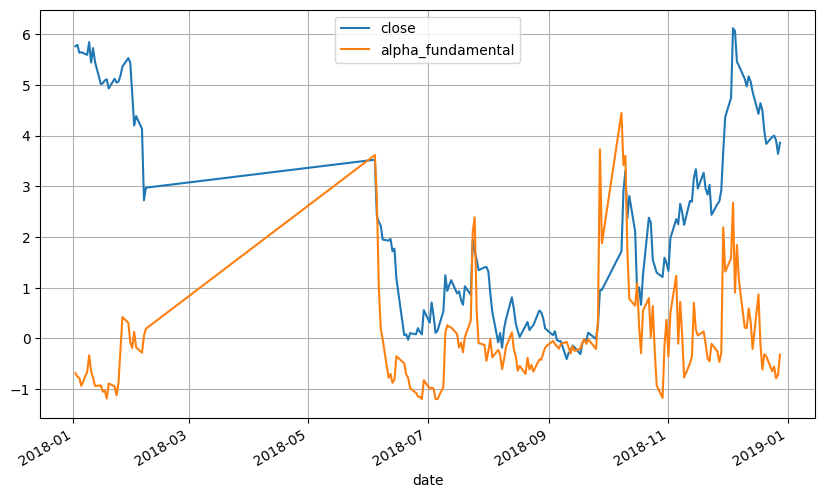

In [198]:
from scipy.stats import zscore
tmp = universe_raw.loc[universe_raw.ts_code=='603538.SH']
tmp = tmp.loc[(tmp['trade_date']>20180101) & (tmp['trade_date']<20190101)]
tmp[['close_5_sma','alpha_fundamental']] = tmp[['close_5_sma','alpha_fundamental']].apply(zscore)
tmp['close'] = tmp['close']-10
tmp[['close','alpha_fundamental']].plot(grid=True)